In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import re
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.model_selection import train_test_split

import xgboost as xgb

from tensorflow.keras.layers import Dense,Dropout,Activation

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")


# 1. Loading the Data

In [2]:
data=pd.read_csv("SolarPrediction.csv")
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# 2. Data Wrangling

In [4]:
df=data.copy()
df['Data']=df['Data'].apply(lambda x: x.split()[0])

In [5]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [6]:
df['Month']=pd.to_datetime(df['Data']).dt.month
df['Day']=pd.to_datetime(df['Data']).dt.day

df['Hour']=pd.to_datetime(df['Time']).dt.hour
df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second

In [7]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


In [8]:
df['risehour']=df['TimeSunRise'].apply(lambda x: re.search(r'^\d',x).group(0)).astype(int)
df['riseminute']=df['TimeSunRise'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)',x).group(0)).astype(int)

df['sethour']=df['TimeSunSet'].apply(lambda x: re.search(r'^\d',x).group(0)).astype(int)
df['setminute']=df['TimeSunSet'].apply(lambda x: re.search(r'(?<=\:)\d+(?=\:)',x).group(0)).astype(int)

In [9]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,0,13,1,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,0,13,1,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,0,13,1,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,0,13,1,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,0,13,1,13


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int64  
 12  Day                     32686 non-null  int64  
 13  Hour                    32686 non-null  int64  
 14  Minute                  32686 non-null

In [11]:
df=df.drop(columns=['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1)

In [12]:
df

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,0,13,1,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,0,13,1,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,0,13,1,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,0,13,1,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,0,13,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1.22,44,30.43,102,145.42,6.75,12,1,0,20,4,0,41,1,42
32682,1.17,44,30.42,102,117.78,6.75,12,1,0,15,1,0,41,1,42
32683,1.20,44,30.42,102,145.19,9.00,12,1,0,10,1,0,41,1,42
32684,1.23,44,30.42,101,164.19,7.87,12,1,0,5,2,0,41,1,42


In [13]:
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
risehour                  0
riseminute                0
sethour                   0
setminute                 0
dtype: int64

In [14]:
input_features=df.drop(['Radiation'],axis=1)
target=df['Radiation']

# 3. Feature Selection using Correlation Matrix

In [15]:
corr_matrix=df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,NaN,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,NaN,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,NaN,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,NaN,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,NaN,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,NaN,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,NaN,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,NaN,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,NaN,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,NaN,-0.002215


<AxesSubplot: >

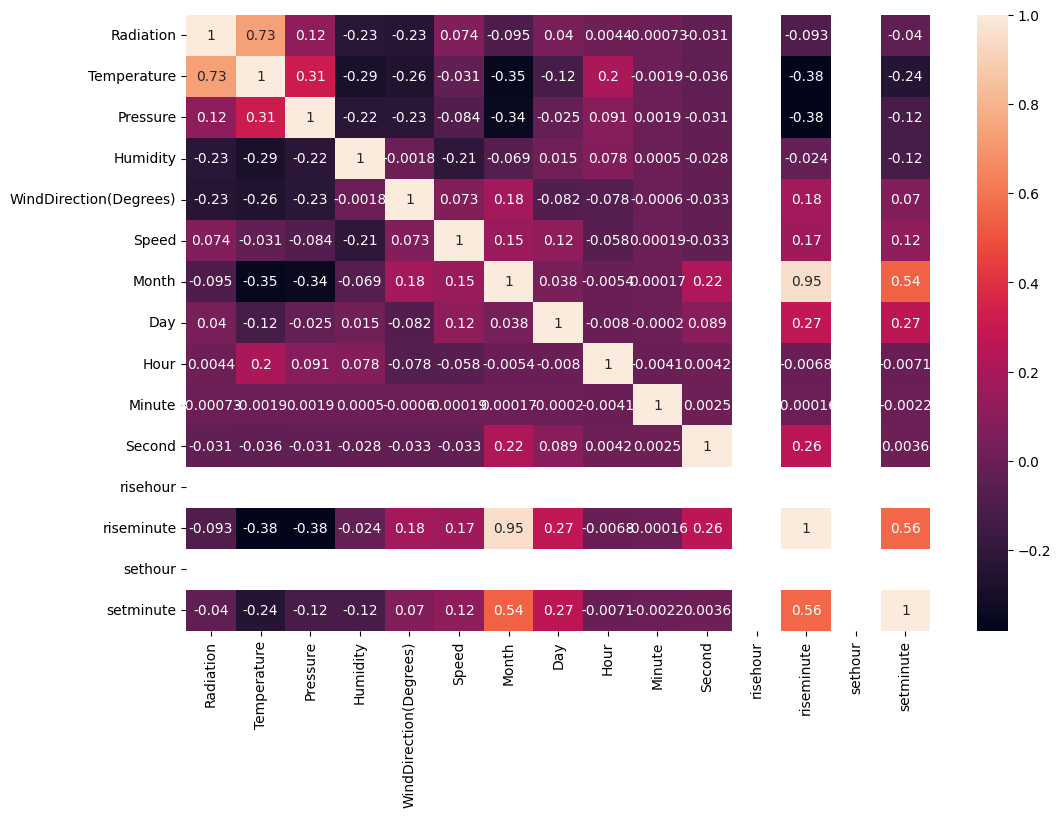

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

# 4. Feature Selection using SelectKBest Method

In [17]:
best_features=SelectKBest(score_func=chi2,k=10)

In [18]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
train_y=le.fit_transform(target)

In [19]:
target_cont=df['Radiation'].apply(lambda x: (int (x*100)))

In [20]:
scaled_input_features=MinMaxScaler().fit_transform(input_features)
fit=best_features.fit(scaled_input_features,target_cont)

In [21]:
scores=pd.DataFrame(fit.scores_)
column=pd.DataFrame(input_features.columns)

In [22]:
feature_scores=pd.concat([column,scores],axis=1)

In [23]:
feature_scores.columns=['Features','feature_imp']
feature_scores

,Features,feature_imp
0,Temperature,1651.685632
1,Pressure,523.791060
2,Humidity,1588.087433
3,WindDirection(Degrees),3271.827277
4,Speed,765.859779
5,Month,4684.579610
6,Day,2841.926850
7,Hour,691.185393
8,Minute,2702.449333
9,Second,2288.673032


In [24]:
feature_scores.sort_values(by="feature_imp",ascending=False,inplace=True)

In [25]:
feature_scores

,Features,feature_imp
5,Month,4684.579610
11,riseminute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433
4,Speed,765.859779


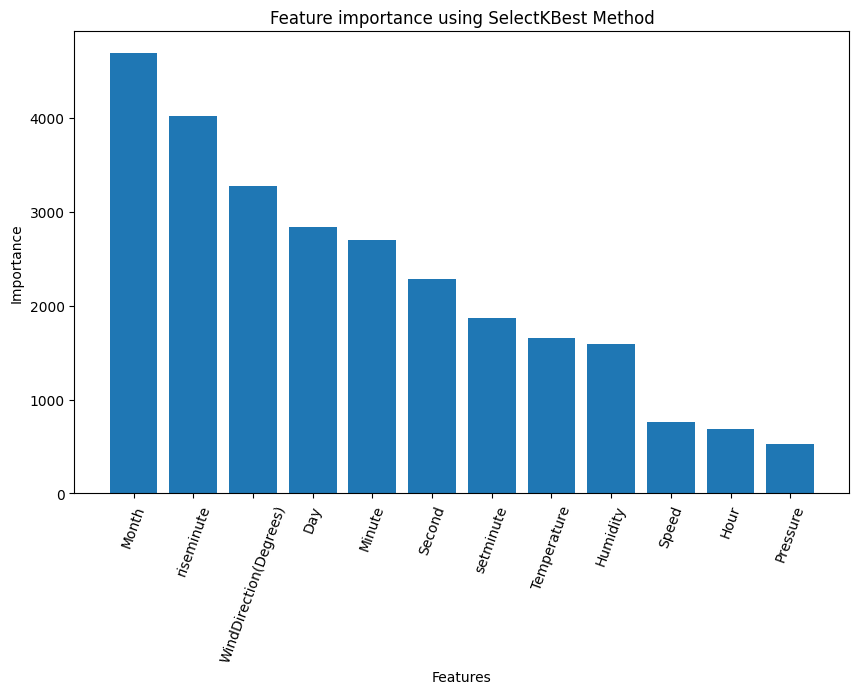

In [26]:
plt.figure(figsize=(10,6))
plt.bar(feature_scores.Features,feature_scores.feature_imp)
plt.xticks(rotation=70)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importance using SelectKBest Method")
plt.show()

# 5. Feature Engineering with BoxCox,Log,MinMax and StandardTransformation

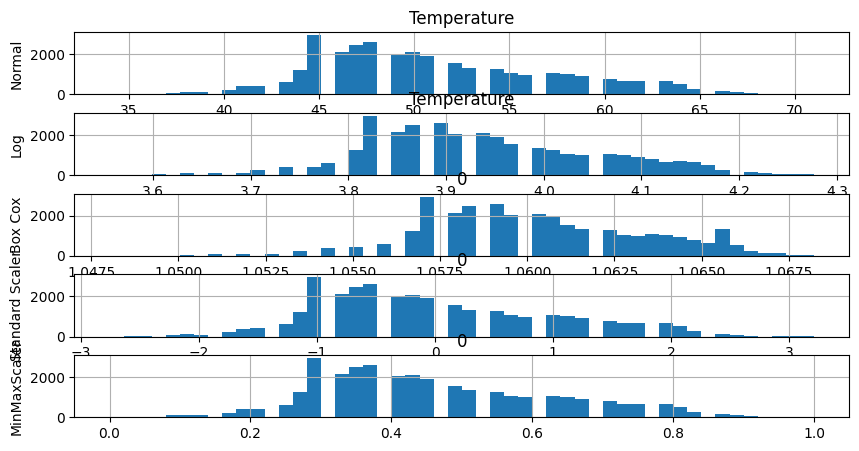

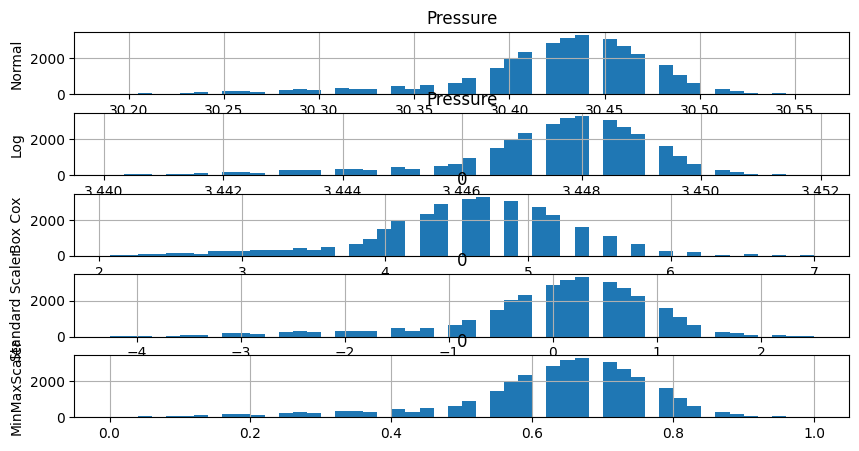

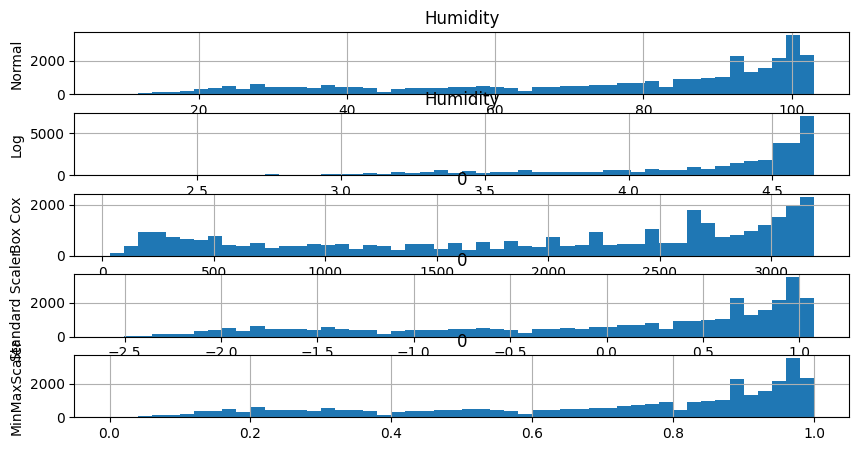

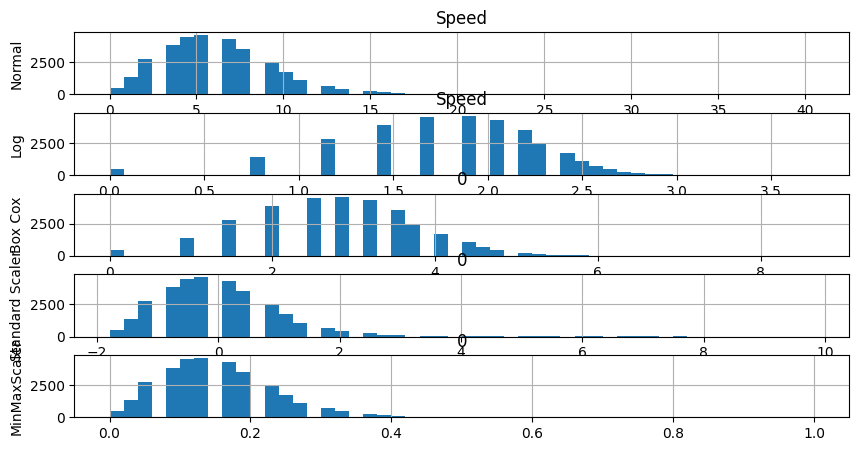

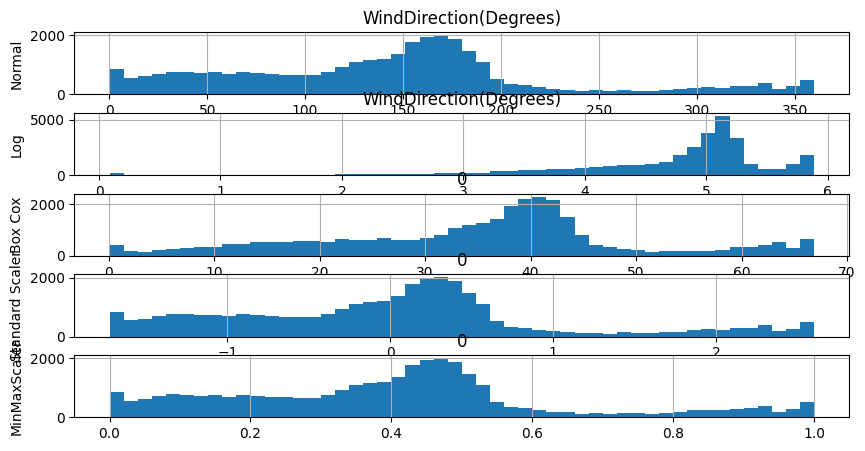

In [35]:
features_to_transform=['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']
for i in features_to_transform:
    fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(5,1,figsize=(10,5))
    
    pd.DataFrame(input_features[i]).hist(ax=ax1,bins=50)
    pd.DataFrame(input_features[i]+1).transform(np.log).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i].values.reshape(-1, 1)))).hist(ax=ax4,bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i].values.reshape(-1,1)))).hist(ax=ax5,bins=50)
                                              
    ax1.set_ylabel("Normal") 
    ax2.set_ylabel("Log")                                            
    ax3.set_ylabel("Box Cox")                                            
    ax4.set_ylabel("Standard Scaler")  
    ax5.set_ylabel("MinMaxScaler")                                            

In [39]:
transform={'Temperature':(input_features['Temperature']+1).transform(np.log),
           'pressure':stats.boxcox(input_features['Pressure']+1)[0],
           'Humidity':stats.boxcox(input_features['Humidity']+1)[0],
           'Speed':(input_features['Speed']+1).transform(np.log),
           'WindDirection(Degrees)':MinMaxScaler().fit_transform(np.array(input_features['WindDirection(Degrees)'].values.reshape(-1,1)))
    
}

In [40]:
for i in transform:
    input_features[i]=transform[i]

In [41]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminute,sethour,setminute,pressure
0,3.89182,30.46,1139.358665,0.492692,1.890095,9,29,23,55,26,0,13,1,13,5.044903e+152
1,3.89182,30.46,1104.046980,0.490996,1.474763,9,29,23,50,23,0,13,1,13,5.044903e+152
2,3.89182,30.46,1069.253545,0.440894,1.474763,9,29,23,45,26,0,13,1,13,5.044903e+152
3,3.89182,30.46,1175.187489,0.382426,1.474763,9,29,23,40,21,0,13,1,13,5.044903e+152
4,3.89182,30.46,1248.392213,0.291391,1.890095,9,29,23,35,24,0,13,1,13,5.044903e+152


# Preparing data-Standardization and Splitting

In [42]:
xtrain,xtest,ytrain,ytest=train_test_split(input_features,target,test_size=0.2,random_state=1)

scaler=StandardScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.fit_transform(xtest)

# XGBoost

In [43]:
from xgboost import XGBRegressor

params={
    "learning_rate":0.1,
    "max_depth":8
}

model=XGBRegressor(**params)

In [44]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [45]:
ypred=model.predict(xtest)

In [46]:
rmse=np.sqrt(mean_squared_error(ytest,ypred))
r2=r2_score(ytest,ypred)

In [47]:
rmse

81.82133783639138

In [48]:
r2

0.9312718360902787

# Using Multilayer Perceptron for Prediction

In [53]:
model=None
model=Sequential()

model.add(Dense(128,activation="relu",input_dim=15))
model.add(Dropout(0.33))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.33))

model.add(Dense(32,activation="relu"))
model.add(Dropout(0.33))

model.add(Dense(1,activation="relu"))
model.add(Dropout(0.33))

model.compile(metrics="mse",loss="mae",optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2048      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

In [54]:
history=model.fit(xtrain,ytrain,validation_split=0.1,epochs=50,batch_size=32)

Epoch 1/50
736/736 [==============================] - 5s 5ms/step - loss: 151.2870 - mse: 85184.4453 - val_loss: 101.6146 - val_mse: 38066.2461
Epoch 2/50
736/736 [==============================] - 3s 4ms/step - loss: 128.5759 - mse: 67544.7266 - val_loss: 100.8460 - val_mse: 37551.7422
Epoch 3/50
736/736 [==============================] - 3s 5ms/step - loss: 126.4373 - mse: 66373.5156 - val_loss: 96.6587 - val_mse: 33986.6875
Epoch 4/50
736/736 [==============================] - 3s 4ms/step - loss: 123.2299 - mse: 64123.0508 - val_loss: 98.5775 - val_mse: 35549.5234
Epoch 5/50
736/736 [==============================] - 3s 4ms/step - loss: 123.7019 - mse: 64914.7539 - val_loss: 90.1487 - val_mse: 30217.9004
Epoch 6/50
736/736 [==============================] - 3s 5ms/step - loss: 120.1947 - mse: 62348.9141 - val_loss: 88.8959 - val_mse: 29609.2266
Epoch 7/50
736/736 [==============================] - 4s 5ms/step - loss: 119.3133 - mse: 61600.9219 - val_loss: 87.0753 - val_mse: 28519.10

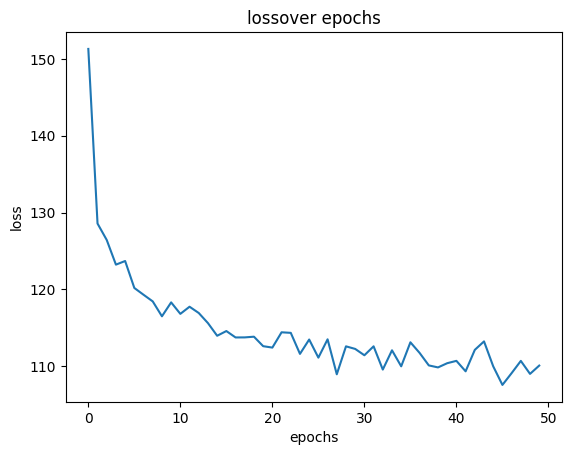

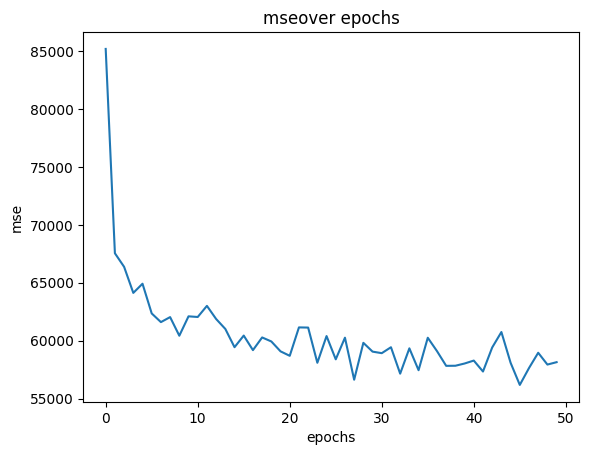

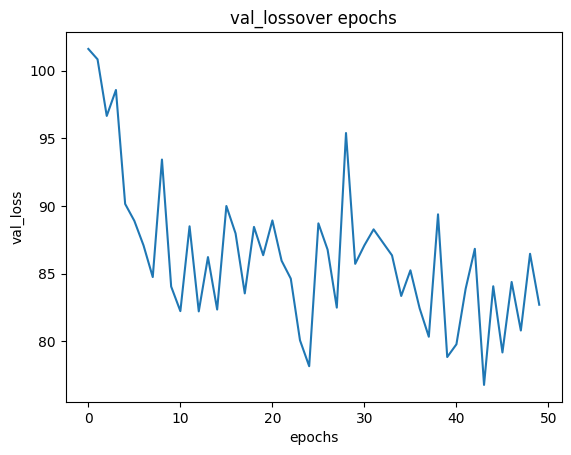

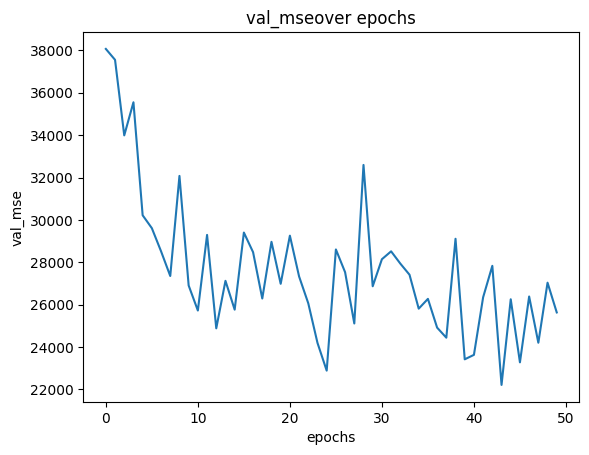

In [55]:
fit=history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i+ 'over epochs')
    plt.ylabel(i)
    plt.xlabel("epochs")
    plt.show()

In [56]:
ypred=model.predict(xtest)

205/205 [==============================] - 1s 2ms/step


In [57]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ypred,ytest)

79.64149089031645